# OSMNX Maps
Making and modifying OSMNX maps.

In [4]:
# Imports and stuff
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import time
import matplotlib.pyplot as plt
#dataframe
df = pd.read_csv('./data/wolt21.csv')

#Print log (not obligatory)
ox.config(log_console=True)
ox.__version__
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# Progress Bar for Monte Carlo Simulations
def progress_bar(current, total, start_time, current_time, bar_length = 30):
    runtime = round(current_time - start_time, 2)
    loop = round(runtime / (current + 1),2)
    eta = round((loop * (total - current))/60,2)
    percent = float(current) * 100 / total
    arrow   = '-' * int(percent/100 * bar_length - 1) + '>'
    spaces  = ' ' * (bar_length - len(arrow))

    print('Progress: [%s%s] %d %%' % (arrow, spaces, percent) + "  runtime: %s s, loop: %s s, eta: %s min" % (runtime, loop, eta), end='\r')

## Making a map
This map will cover all the deliveries in the Wolt dataset

In [ ]:
### MAKING A MAP OF WOLT DELIVERIES: depends on the max and min coordinates of all of the deliveries
df = pd.read_csv('./data/wolt21.csv')

#Figuring out the size of the map
lat_min=min([min(df.USER_LAT), min(df.VENUE_LAT)])
lat_max=max([max(df.USER_LAT), max(df.VENUE_LAT)])
lon_min=min([min(df.USER_LONG), min(df.VENUE_LONG)])
lon_max=max([max(df.USER_LONG), max(df.VENUE_LONG)])
print(lat_min, lat_max, lon_min, lon_max)
# Checking these coordinates it shows that the deliveries are in the area from Lauttasaari to Viikki

north, south, east, west = lat_min, lat_max, lon_min, lon_max

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="walk")

fig, ax = ox.plot_graph(G, node_color="#00c2e8", node_size=0.5)

# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G, filepath="./data/wolt_network_walk.graphml")

# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

## Adding Elevation
First for the real map, then for the condensed

In [25]:
### Adding elevation
### OPEN API: https://www.opentopodata.org/
## load megamap
G = ox.load_graphml("./data/wolt_network_walk.graphml")
import requests
import json
start_time = time.time()
i=0
while i < len(G.nodes)-38: # 144 rounds, 37 remainder (len(G.nodes)-1)

    #requesting the data
    URL= 'https://api.opentopodata.org/v1/test-dataset?locations='
    POINTS =''
    for u in range(0,100):
        node_id = list(G.nodes)[u+i]
        lon=G.nodes[node_id]['x'] #lon
        lat=G.nodes[node_id]['y'] #lat
        POINTS=POINTS + (str(lat) +','+str(lon)+'|')
    x = requests.get(URL+POINTS)
    progress_bar(i, len(G.nodes)-15, start_time, time.time())
    time.sleep(1) #Added delay so that the API doesn't get mad.

    #saving the data to G
    for j in range(0,100):
        G.nodes[list(G.nodes)[i+j]]['elevation'] = x.json()['results'][j]['elevation']
    
    i=i+100
### LAST 37 points ###
#requesting the data
URL= 'https://api.opentopodata.org/v1/test-dataset?locations='
POINTS =''
for u in range(0,37):
    node_id = list(G.nodes)[u+i]
    lon=G.nodes[node_id]['x'] #lon
    lat=G.nodes[node_id]['y'] #lat
    POINTS=POINTS + (str(lat) +','+str(lon)+'|')
x = requests.get(URL+POINTS)

#saving the data to G
for j in range(0,37):
    G.nodes[list(G.nodes)[i+j]]['elevation'] = x.json()['results'][j]['elevation']

### Sanity check
lista=[]
for i in range(0,len(G.nodes)):
    lista.append(G.nodes[list(G.nodes)[i]]['elevation'])
print('Number of nodes without elevation data: '+str(len(G.nodes)-len(lista)))
print('Average of the elevations: '+str(np.mean(lista)))

filepath = "./data/wolt_network_walk_elevation.graphml"
ox.save_graphml(G, filepath)

In [ ]:
### Adding elevation
### OPEN API: https://www.opentopodata.org/
## load megamap
G_mega = ox.load_graphml("./data/wolt_network_walk.graphml")
G = ox.load_graphml("./data/wolt_network_walk_simplified.graphml")
import requests
import json
start_time = time.time()
i=0
while i < len(G.nodes)-15: # 144 rounds, 14 remainder (len(G.nodes)-1)

    #requesting the data
    URL= 'https://api.opentopodata.org/v1/test-dataset?locations='
    POINTS =''
    for u in range(0,100):
        if type(json.loads(G.nodes[u+i]['osmid_original'])) == int: #If there is lat/lon data available (because of simplification)
            POINTS=POINTS + (str(G.nodes[u+i]['lat']) +','+str(G.nodes[u+i]['lon'])+'|')
        else:
            node_id = json.loads(G.nodes[u+i]['osmid_original'])[0] #else: take the lat/lon data from orinigal mega map
            lon=G_mega.nodes[node_id]['x'] #lon
            lat=G_mega.nodes[node_id]['y'] #lat
            POINTS=POINTS + (str(lat) +','+str(lon)+'|')
    x = requests.get(URL+POINTS)
    progress_bar(i, len(G.nodes)-15, start_time, time.time())
    time.sleep(1) #Added delay so that the API doesn't get mad.

    #saving the data to G
    for j in range(0,100):
        G.nodes[i+j]['elevation'] = x.json()['results'][j]['elevation']
    
    i=i+100

### LAST 14 points ###
#requesting the data
URL= 'https://api.opentopodata.org/v1/test-dataset?locations='
POINTS =''
for u in range(0,14):
    if type(json.loads(G.nodes[u+i]['osmid_original'])) == int: #If there is lat/lon data available (because of simplification)
        POINTS=POINTS + (str(G.nodes[u+i]['lat']) +','+str(G.nodes[u+i]['lon'])+'|')
    else:
        node_id = json.loads(G.nodes[u+i]['osmid_original'])[0] #else: take the lat/lon data from orinigal mega map
        lon=G_mega.nodes[node_id]['x'] #lon
        lat=G_mega.nodes[node_id]['y'] #lat
        POINTS=POINTS + (str(lat) +','+str(lon)+'|')
x = requests.get(URL+POINTS)

#saving the data to G
for j in range(0,14):
    G.nodes[i+j]['elevation'] = x.json()['results'][j]['elevation']
    
### Sanity check
lista=[]
for i in range(0,len(G.nodes)):
    lista.append(G.nodes[i]['elevation'])
print('Number of nodes without elevation data: '+str(len(G.nodes)-len(lista)))
print('Average of the elevations: '+str(np.mean(lista)))

filepath = "./data/wolt_network_walk_simplified_elevation.graphml"
ox.save_graphml(G, filepath)

## Simplifying
Simnplying the map. This means combining nodes that are very close to one another (less than 5 m). Those nodes usually are within the same intersection.

In [34]:
### Simplifying the map (making close nodes into one intersection, reducing map size by 6-fold) 45000 nodes to ~8000
G = ox.load_graphml("./data/wolt_network_walk.graphml")
G_proj = ox.project_graph(G)
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=False)
filepath = "./data/wolt_network_walk_simplified.graphml"
ox.save_graphml(G2, filepath)

E:\programs\envs\ox\lib\site-packages\osmnx\simplification.py:423: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoSeries(list(merged), crs=G.graph["crs"])
E:\programs\envs\ox\lib\site-packages\osmnx\simplification.py:423: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoSeries(list(merged), crs=G.graph["crs"])
E:\WINDOW~1\TEMP/ipykernel_17748/1514115406.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=5, dead_ends=False)


## Plotting
1. Just the map
2. /W Elevation

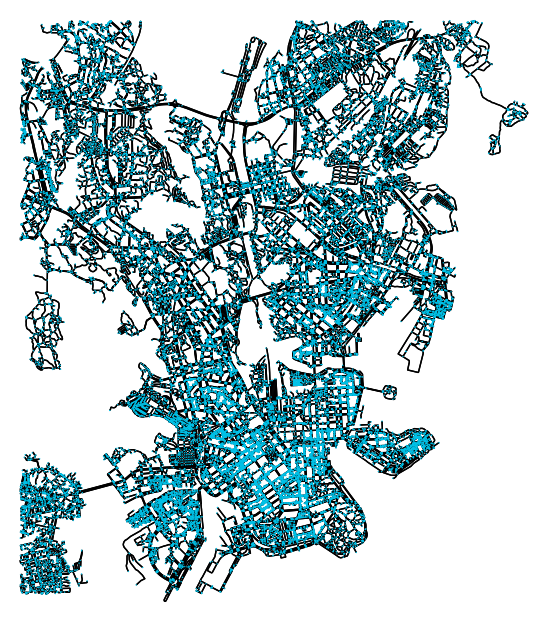

In [2]:
### Plot map ###
G = ox.load_graphml("./data/wolt_network_walk_elevation.graphml")
fig, ax = ox.plot_graph(G, bgcolor="#ffffff",edge_color="#000000", node_color="#00c2e8", node_size=1, save=True, show=False, filepath="./images/wolt_network_walk.png")
#G = ox.load_graphml("./data/wolt_network_walk_simplified_elevation.graphml")
#fig, ax = ox.plot_graph(G, bgcolor="#ffffff",edge_color="#000000", node_color="#00c2e8", node_size=1.5, save=True, show=False, filepath="./images/wolt_network_walk_simplified.png")

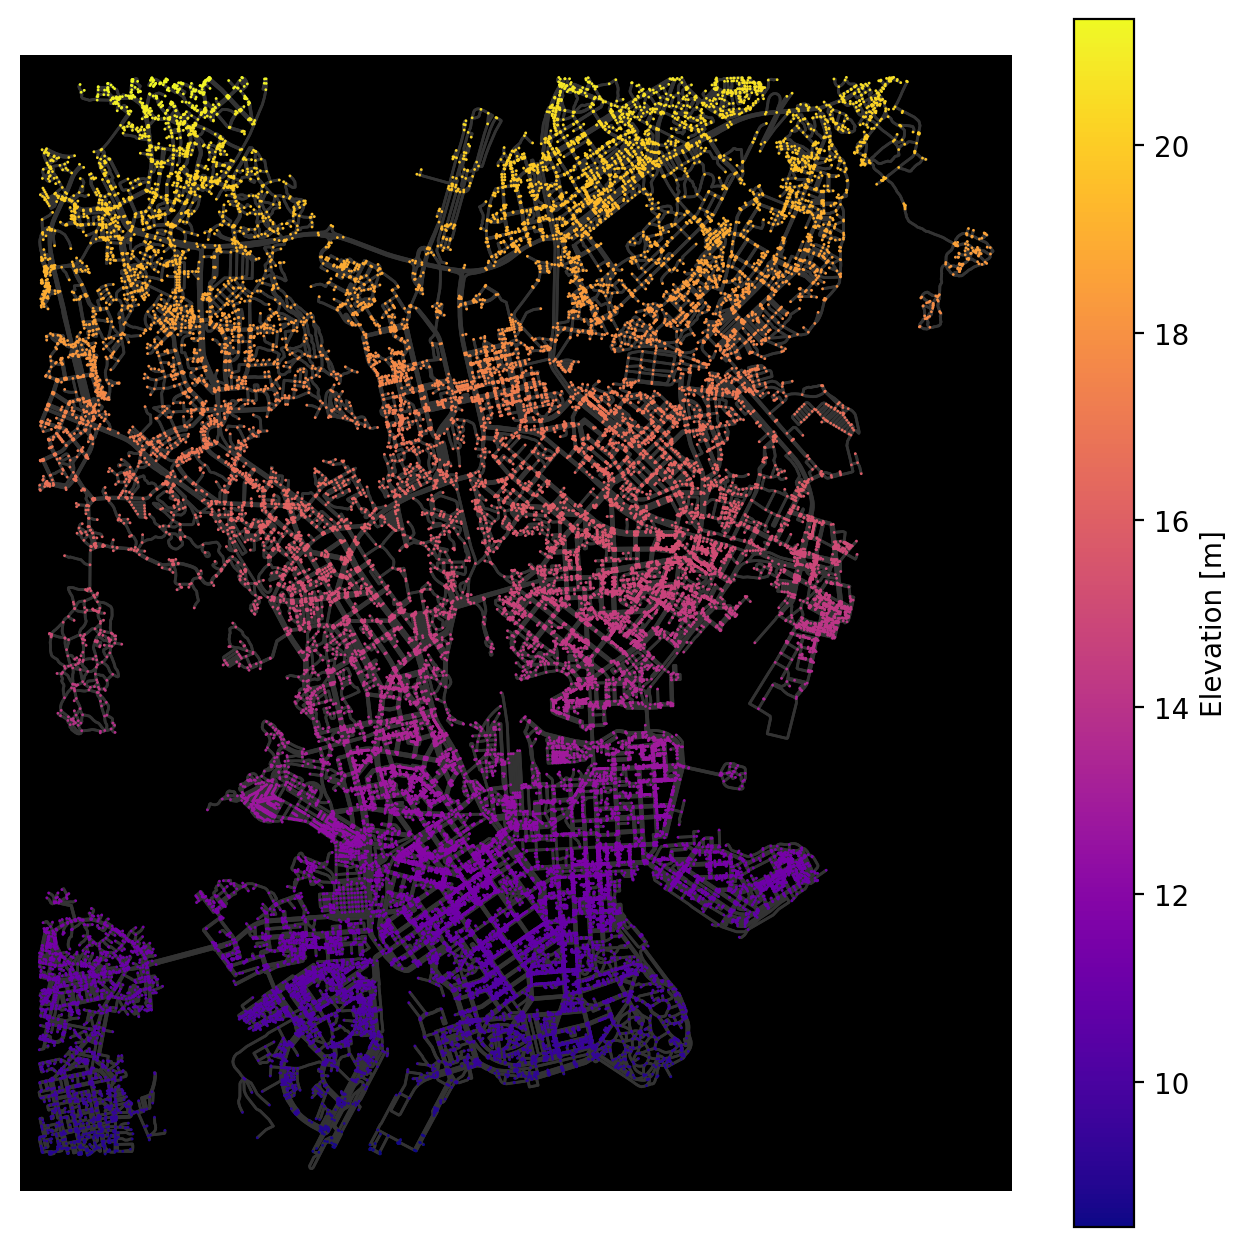

In [5]:
# get one color for each node, by elevation, then plot the network
G = ox.load_graphml("./data/wolt_network_walk_elevation.graphml")
nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
fig, ax = ox.plot_graph(G, node_color=nc, bgcolor="k", node_size=1, edge_color="#333333", show=False)
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
norm=plt.Normalize(vmin=nodes['elevation'].min(), vmax=nodes['elevation'].max())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.plasma), ax=ax)
cb.set_label('Elevation [m]')
plt.savefig('./images/wolt_network_walk_elevation.png')
